Just looking through here:  https://aclanthology.org/2025.nllp-1.5.pdf

I see that in the research paper they reference
https://github.com/EleutherAI/lm-evaluation-harness  
whenever they were talking about using NIAH (kind of confused if they used stuff here to implement the evaluation or in the research paper they implemented NIAH on their own)


Our needles instead of being from the legal domain (specific to the case), need to be equivalent facts from the financial report.

An example table maybe:
| Component      | Original Study (CourtListener)           | Proposed Replication (EDGAR-CORPUS)                                           |
|----------------|-------------------------------------------|-------------------------------------------------------------------------------|
| Document       | US Court Opinion                          | 10-K Filing (Annual Report)                                                   |
| Context        | Full case text                            | Specific Section (e.g., Item 7 “MD&A”)                                       |
| Task 1: Decision | “Affirmed” vs. “Reversed”                 | Sentiment/Profit: “Did the company report a Net Profit or Loss?”             |
| Task 2: Author | Judge/Author Name                         | Entity: “Who is the exact Auditor named in the report?”                      |
| Task 3: Citation | Case Citation (e.g., “302 U.S. 1”)        | Regulation/Figure: “What is the exact ‘Total Assets’ value listed?”          |

In [ ]:
from datasets import load_dataset
import re
import random
from collections import Counter
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:

# ============================================================================
# 1. LOAD DATASET
# ============================================================================

print("Loading EDGAR dataset...")
train_url = "https://huggingface.co/datasets/c3po-ai/edgar-corpus/resolve/refs%2Fconvert%2Fparquet/year_2020/train/0000.parquet"
test_url = "https://huggingface.co/datasets/c3po-ai/edgar-corpus/resolve/refs%2Fconvert%2Fparquet/year_2020/test/0000.parquet"

train_dataset = load_dataset("parquet", data_files={"train": train_url}, split="train")
test_dataset = load_dataset("parquet", data_files={"test": test_url}, split="test")

print(f"Loaded {len(train_dataset)} train examples, {len(test_dataset)} test examples")

Loading EDGAR dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


year_2020/train/0000.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

year_2020/test/0000.parquet:   0%|          | 0.00/83.7M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loaded 2000 train examples, 685 test examples


### **PROBLEMS WITH THIS CODE BELOW**

The problem with this is that using ARBITRARY single-occurrence words:

- Common words like "factory", "press", "notes"
- No reason for the model to pick these over any other word.
- The model doesn't even understand it should find words appearing once.

The original paper uses domain-specific prompts that give the model strong hints about what to look for


In [ ]:
# ============================================================================
# 2. FIND NATURALLY OCCURRING SINGLE-INSTANCE WORDS (Paper's Method)
# ============================================================================

def find_single_occurrence_words(text, min_length=5, max_length=12):
    """
    Find words that appear exactly once in the text.
    This matches the paper's approach of using naturally occurring needles.
    """
    if not text or len(text.strip()) < 100:
        return None

    # Normalize and extract words
    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)

    # Truncate to manageable length (paper uses full docs, but we'll limit for compute)
    if len(words) < 200:  # Too short
        return None

    words = words[:512]  # Limit context window, test repeatedly

    # Count word frequencies
    counts = Counter(words)

    # Find words that appear exactly once and are substantive
    candidates = [
        word for word, count in counts.items()
        if count == 1 and min_length <= len(word) <= max_length
        and word.isalpha()  # No numbers
    ]

    if not candidates:
        return None

    # Pick a random candidate as the "needle"
    needle = random.choice(candidates)
    needle_position = words.index(needle)

    return {
        'words': words,
        'needle': needle,
        'position': needle_position,
        'text': ' '.join(words)
    }

In [ ]:
# ============================================================================
# 3. SHUFFLING FUNCTIONS (Paper's Core Manipulation)
# ============================================================================

def shuffle_by_window(words, window_size):
    """
    Shuffle words within local windows.
    window_size=1: no shuffle
    window_size=3: shuffle triads (paper's local shuffle)
    window_size=len(words): global shuffle (NIAH condition)
    """
    if window_size >= len(words):
        # Global shuffle
        shuffled = words.copy()
        random.shuffle(shuffled)
        return shuffled

    # Local window shuffle
    shuffled = []
    for i in range(0, len(words), window_size):
        window = words[i:i+window_size]
        random.shuffle(window)
        shuffled.extend(window)

    return shuffled

def create_shuffle_conditions(words_list):
    """
    Create multiple shuffle conditions for the SAME document.
    This is the paper's key innovation.
    """
    return {
        'standard': words_list,  # Original order
        'triad': shuffle_by_window(words_list.copy(), 3),  # Local shuffle
        'sentence': shuffle_by_window(words_list.copy(), 15),  # Approx sentence
        'paragraph': shuffle_by_window(words_list.copy(), 50),  # Approx paragraph
        'global': shuffle_by_window(words_list.copy(), len(words_list))  # NIAH
    }

In [ ]:
import numpy as np
# ============================================================================
# 4. PREPARE TEST CASES
# ============================================================================

print("\nPreparing test cases with naturally occurring needles...")
random.seed(42)

test_cases = []
for example in tqdm(test_dataset, desc="Finding single-occurrence words"):
    result = find_single_occurrence_words(example['section_7'])
    if result:
        test_cases.append(result)

    if len(test_cases) >= 100:  # Get 100 valid test cases
        break

print(f"Created {len(test_cases)} test cases with natural needles")

# Sample statistics
needle_lengths = [len(case['needle']) for case in test_cases]
print(f"Needle length stats: min={min(needle_lengths)}, max={max(needle_lengths)}, avg={np.mean(needle_lengths):.1f}")


Preparing test cases with naturally occurring needles...


Finding single-occurrence words:  16%|█▋        | 112/685 [00:00<00:02, 233.38it/s]

Created 100 test cases with natural needles
Needle length stats: min=5, max=12, avg=7.8


In [ ]:
 # ============================================================================
# 5. MODEL SETUP
# ============================================================================

MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"
print(f"\nLoading {MODEL_ID}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

print("Model loaded successfully")


Loading Qwen/Qwen2.5-3B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model loaded successfully


In [ ]:
# ============================================================================
# 6. EVALUATION FUNCTION
# ============================================================================

def query_model(prompt, max_tokens=30):
    """Query the model with a prompt"""
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Answer concisely with just the requested word."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_tokens,
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_ids = [
        output_ids[len(input_ids):]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    return response

def check_answer(response, target):
    """Check if the response contains the target word"""
    response_lower = response.lower().strip()
    target_lower = target.lower().strip()

    # Extract first word from response
    response_words = response_lower.split()
    if response_words and response_words[0] == target_lower:
        return True

    # Also check exact match
    if response_lower == target_lower:
        return True

    # Check if target is contained (more lenient)
    if target_lower in response_lower:
        return True

    return False

In [ ]:
# ============================================================================
# 7. RUN THE EXPERIMENT (Following Paper's Protocol)
# ============================================================================

def run_paper_experiment(test_cases, num_samples=50):
    """
    Run experiment following the paper's methodology:
    - Same document tested under multiple shuffle conditions
    - Measure accuracy across conditions
    """
    results = []

    for i, case in enumerate(tqdm(test_cases[:num_samples], desc="Running experiment")):
        needle = case['needle']
        words = case['words']

        # Create all shuffle conditions for THIS SAME DOCUMENT
        conditions = create_shuffle_conditions(words)

        # Test each condition
        condition_results = {'needle': needle, 'position': case['position']}

        for condition_name, shuffled_words in conditions.items():
            text = ' '.join(shuffled_words)

            # Create prompt (similar to paper's "Decision" task)
            prompt = (
                f"In the following text, identify a word that appears exactly once. "
                f"Respond with only that word.\n\n"
                f"Text: {text}\n\n"
                f"Word that appears once:"
            )

            # Query model
            response = query_model(prompt)
            is_correct = check_answer(response, needle)

            condition_results[f'{condition_name}_response'] = response
            condition_results[f'{condition_name}_correct'] = is_correct

        results.append(condition_results)

    return pd.DataFrame(results)

In [ ]:
# ============================================================================
# 8. RUN THE EXPERIMENT
# ============================================================================

print("\n" + "="*70)
print("RUNNING EXPERIMENT (Paper's Methodology)")
print("="*70)

df_results = run_paper_experiment(test_cases, num_samples=50)



RUNNING EXPERIMENT (Paper's Methodology)


Running experiment: 100%|██████████| 50/50 [06:54<00:00,  8.29s/it]


In [ ]:

# ============================================================================
# 9. CALCULATE ACCURACIES (Recreate Paper's Table 2)
# ============================================================================

accuracies = {}
for condition in ['standard', 'triad', 'sentence', 'paragraph', 'global']:
    acc = df_results[f'{condition}_correct'].mean()
    accuracies[condition] = acc

print(f"\n{'='*70}")
print(f"RESULTS (n={len(df_results)}) - Recreating Paper's Findings")
print(f"{'='*70}")
print(f"Standard (Original):      {accuracies['standard']:.1%}")
print(f"Triad Shuffle (Local):    {accuracies['triad']:.1%}")
print(f"Sentence Shuffle:         {accuracies['sentence']:.1%}")
print(f"Paragraph Shuffle:        {accuracies['paragraph']:.1%}")
print(f"Global Shuffle (NIAH):    {accuracies['global']:.1%}")
print(f"{'='*70}")

# Paper's key finding: J-shaped curve
print(f"\nKey Findings:")
print(f"- Drop from Standard to Local: {(accuracies['standard'] - accuracies['triad']):.1%}")
print(f"- Rise from Local to Global: {(accuracies['global'] - accuracies['triad']):.1%}")
print(f"- Global vs Standard gap: {(accuracies['global'] - accuracies['standard']):.1%}")


RESULTS (n=50) - Recreating Paper's Findings
Standard (Original):      0.0%
Triad Shuffle (Local):    2.0%
Sentence Shuffle:         0.0%
Paragraph Shuffle:        0.0%
Global Shuffle (NIAH):    0.0%

Key Findings:
- Drop from Standard to Local: -2.0%
- Rise from Local to Global: -2.0%
- Global vs Standard gap: 0.0%


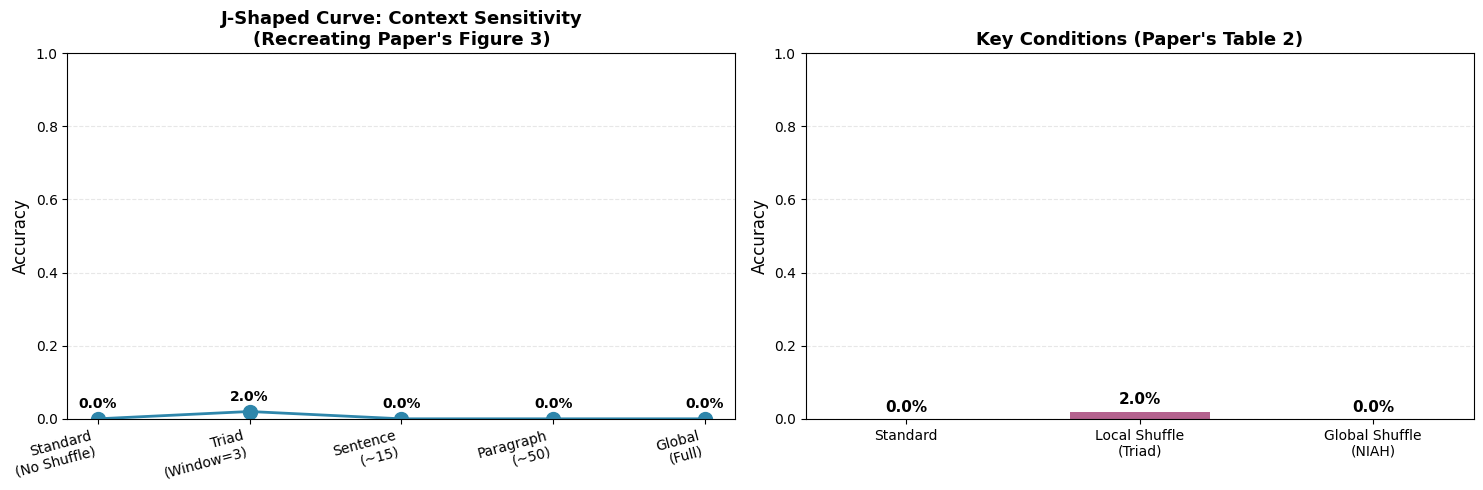

In [ ]:
# ============================================================================
# 10. VISUALIZE THE J-CURVE (Paper's Figure 3)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: J-Curve (shuffle window size vs accuracy)
ax1 = axes[0]
shuffle_sizes = [1, 3, 15, 50, 512]  # Standard, Triad, Sentence, Para, Global
shuffle_labels = ['Standard\n(No Shuffle)', 'Triad\n(Window=3)',
                  'Sentence\n(~15)', 'Paragraph\n(~50)', 'Global\n(Full)']
acc_values = [
    accuracies['standard'],
    accuracies['triad'],
    accuracies['sentence'],
    accuracies['paragraph'],
    accuracies['global']
]

ax1.plot(range(len(shuffle_sizes)), acc_values, 'o-', linewidth=2,
         markersize=10, color='#2E86AB')
ax1.set_xticks(range(len(shuffle_sizes)))
ax1.set_xticklabels(shuffle_labels, rotation=15, ha='right')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('J-Shaped Curve: Context Sensitivity\n(Recreating Paper\'s Figure 3)',
              fontsize=13, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add annotations
for i, acc in enumerate(acc_values):
    ax1.text(i, acc + 0.03, f'{acc:.1%}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Comparison (recreating paper's Table 2)
ax2 = axes[1]
conditions = ['Standard', 'Local Shuffle\n(Triad)', 'Global Shuffle\n(NIAH)']
values = [accuracies['standard'], accuracies['triad'], accuracies['global']]
colors = ['#2E86AB', '#A23B72', '#06A77D']

bars = ax2.bar(conditions, values, color=colors, alpha=0.8, width=0.6)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Key Conditions (Paper\'s Table 2)', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.1%}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 11. SAMPLE OUTPUTS AND ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("SAMPLE OUTPUTS")
print("="*70)

# Show cases demonstrating the J-curve pattern
for idx in range(min(3, len(df_results))):
    row = df_results.iloc[idx]
    print(f"\nExample {idx+1}:")
    print(f"Needle: '{row['needle']}'")
    print(f"Standard: {row['standard_response'][:50]} {'✓' if row['standard_correct'] else '✗'}")
    print(f"Triad:    {row['triad_response'][:50]} {'✓' if row['triad_correct'] else '✗'}")
    print(f"Global:   {row['global_response'][:50]} {'✓' if row['global_correct'] else '✗'}")

# Count pattern types
both_correct = ((df_results['standard_correct']) & (df_results['global_correct'])).sum()
std_only = ((df_results['standard_correct']) & (~df_results['global_correct'])).sum()
global_only = ((~df_results['standard_correct']) & (df_results['global_correct'])).sum()
both_wrong = ((~df_results['standard_correct']) & (~df_results['global_correct'])).sum()

print(f"\n{'='*70}")
print("PATTERN ANALYSIS")
print(f"{'='*70}")
print(f"Both Standard & Global correct: {both_correct} ({both_correct/len(df_results):.1%})")
print(f"Only Standard correct:          {std_only} ({std_only/len(df_results):.1%})")
print(f"Only Global (NIAH) correct:     {global_only} ({global_only/len(df_results):.1%})")
print(f"Both wrong:                     {both_wrong} ({both_wrong/len(df_results):.1%})")
print(f"{'='*70}")

print("\nPaper's Key Insight:")
print("Models perform BETTER on globally shuffled text than coherent text!")
print("This suggests they rely on 'reading' (context cues) rather than pure 'recall'.")
print("When forced into pure recall mode (global shuffle), they actually do better.")


SAMPLE OUTPUTS

Example 1:
Needle: 'factory'
Standard: fusion ✗
Triad:    biotechnology ✗
Global:   biologics ✗

Example 2:
Needle: 'press'
Standard: cautionary ✗
Triad:    conjunction ✗
Global:   litigation ✗

Example 3:
Needle: 'notes'
Standard: tivo ✗
Triad:    food ✗
Global:   cancer ✗

PATTERN ANALYSIS
Both Standard & Global correct: 0 (0.0%)
Only Standard correct:          0 (0.0%)
Only Global (NIAH) correct:     0 (0.0%)
Both wrong:                     50 (100.0%)

Paper's Key Insight:
Models perform BETTER on globally shuffled text than coherent text!
This suggests they rely on 'reading' (context cues) rather than pure 'recall'.
When forced into pure recall mode (global shuffle), they actually do better.
